# 10-K Insights: Sentiment Analysis and Stock Returns for S&P500 Stocks in 2022

Nicole ElChaar, FIN377, Spring 2023

## Summary

10-K filings are a rich source of information for investors and are expected to be objective and factual.  In this analysis, we explore whether 10-K filings implicitly contain value-relevant information in the sentiment of the text.

We examine the relationships between sentiments found in 10-K filings and returns following the 10-K's release using two valence-based dictionaries and three topic-based schemes (with financial stability, corporate governance, and e-commerce themes).  We find higher absolute correlations for positive sentiments in general, with the largest magnitudes for positive e-commerce topics, positive LM sentiment, negative LM sentiment, and positive financial stability topics.

### Setup

In [1]:
# Data manipulation packages
import numpy as np
import pandas as pd
import re

# Plotting and regression packages
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.formula.api import ols as sm_ols

# Directories and display settings
pd.set_option('display.max_columns', None)
output_dir = 'output/'
df_path = output_dir + '/analysis_sample.csv'

In [2]:
# Load in dataset
df = pd.read_csv(df_path)
df_sents = df.filter(regex='^.*_(posi|nega)tive$|^ret_t.*$', axis=1)

## Data


### The Sample

This exploration is limited to a set of S&P500 stocks in the first quarter of 2023.  The final output is *output/analysis_sample.csv*, where each observance is a ticker in the S&P500.  Columns include:

1. the return from the day of the company's 10-K release to two days following the 10-K's release
1. the return from three days following the company's 10-K release to ten days following the 10-K's release
1. 5 positive sentiment scores as percents of the document
1. 5 negative sentiment scores as percents of the document
1. the 10-K's word count
1. the 10-K's unique word word
1. various accounting variables from 2021

### Computing the Returns

To compute the returns from the day of the 10-K release until 10 days following the 10-K's release, we start by loading in 2022 daily returns from the CSRP via the LeDataSciFi/data folder on GitHub.  The loaded dataset contains three columns (the ticker, date, and percent return) and 2,586,006 rows for returns from 12/01/2021 to 12/30/2022.  The table is stored in its own data frame.

Once returns are loaded, we now must filter them to include only those up to ten days after each 10-K's release.  We get the filing date for each 10-K from SEC EDGAR.  With the CIK of the company and the accession number of the 10-K, we extract the filing date from the HTML on the page and add it as an additional column in our table of S&P500 stock identifiers.  Because EDGAR limits users to ten requests per second, we pause for one tenth of a second between each subsequent request.

Now, we can join and filter the returns by the gathered filing dates.  Dates must be greater than or equal to the filing date so that we only examine returns after additional information was released.  The return table only includes returns on trading days, so after sorting by date and grouping by ticker, we can filter to the top eleven rows with dates greater than or equal to the 10-K's release day.  Note that we do not have returns into 2023, so some late 2022 releases do not contain returns over the entire expected period.

Mechanically, this is done by merging the table with filing dates to the table with returns with a left join.  We expect each ticker to have many returns in the returns table, so we validate one-to-many and match tickers between the tables.  Then, we filter the merged set.  Only dates greater than or equal to the filing date are included.  After sorting by ascending date and grouping by ticker, we select the top eleven rows of each ticker with `head`.

The formula for creating the cumulative return over each period is below.

$$R_c = \prod_{i=1}^{n} (1 + r_i) - 1 $$

$R_c$ is the cumulative return, $r_i$ is the daily return for each day in the period, and $n$ is the number of days in the period.


In Python, we introduce a new column in the data frame that is 1 + the return.  Then, we compute the cumulative product of this variable with `cumprod` over the top 3 elements by ticker (`head`) and the bottom 8 elements by ticker (`tail`).  The last element of each section is the cumulative return for the period and is stored.

### Computing the Sentiment Measures

After cleaning the 10-Ks to remove any metadata and formatting characters, we can use regex to search for patterns in each 10-K.  Sentiment measures are computed by the percent of words matching the pattern divided by the total word length of the document.  10-Ks are cleaned by removing xml notation and punctuation.  We replace uppercase letters with lowercase letters and ensure that the document is single-spaced.

The ML and LM dictionaries match to a single list of strings.  We format the regex pattern to match the format of our 10-K documents (removing punctuation, changing to lowercase) and find the length of the total matches in the document with `findall` of the `re` package.

#### Contextual Sentiment Topic Selection

For contextual sentiment topic selection, we use the same method of summing the length of the matches and dividing by the total length of the document, but we match to spaced topics instead of single words.  For each topic, we generate a list of neutral words associated with that topic.  We add in a list of positive and negative words associated with those neutral words.

In my exploration, I assumed that negative words in 10-Ks would be more nuanced as to not alarm shareholders.  I used positive topic words to indicate advancing in a particular topic and negative words to indicate staying stagnant or regressing in some topic.

I created a total of fifteen custom topics with positive and negative associations.  Of the fifteen topics, I selected those with the highest absolute correlation with the return variables for this report.  All topic words are loaded from *inputs/topic_list.csv*.

With `NEAR_regex`, we allow up to 5 words between neutral topics and their positive or negative adjustment words.  Because technical sentences tend to range from 15 to 20 words, a maximum of 5 words between topics allows for variance in sentence structure without losing the original subject.  Using more or fewer words led to slightly lower regression results.  We do not use partial matches to avoid impacting existing corpuses (see Financial Stability), though they could be useful to better generalize to additional tenses and phrasing.

##### Financial Stability

**`fs`** stands for Financial Stability and includes 75 topic phrases, 295 negative phrases, and 96 positive phrases.  This corpus was borrowed from Correa et al.[[1]](#1) and is the largest and most general topic I explored.  Though a good portion of the data overlaps with the LM dictionary, it adds positive and negative sentiment to topic words and adds over 120 words beyond the LM dictionary alone.

##### Corporate Governance

**`cg`** stands for Corporate Governance and includes 21 topic phrases, 14 negative phrases, and 19 positive phrases.  We search for neutral topics of leadership, governance, board composition, risks, and management and see how they are described in each 10-K.

##### E-Commerce

**`ecom`** refers to E-Commerce and includes 12 topic phrases, 10 negative phrases, and 14 positive phrases.  We look for topics related to digital payments, online advertising, mobile commerce, and social media and attempt to explore if companies are embracing new online trends.

### Analysis Sample

Looking into the sample, we find returns for 497 of the 503 included stocks and sentiment results for all 500 of the 503 included stocks.

Of the contextual sentiment measures, financial stability appears the most frequently (consistent with the number of terms and their applicability regardless of the firms' industry).  E-commerce appears the most infrequently, consistent with the length of the topic list and niche.  Despite this, both positive and negative e-commerce sentiments are present in some 10-Ks, with scores greater than 0 for 242 firms with positive e-commerce sentiments and scores greater than 0 for 75 firms with negative e-commerce sentiments.  All measures have some variance and are within the expected range of low percentages.

In [3]:
df_sents.describe()

,ret_t-t2,ret_t3-t10,bhr_negative,bhr_positive,lm_negative,lm_positive,fs_negative,fs_positive,cg_negative,cg_positive,ecom_negative,ecom_positive
count,497.000000,497.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000
mean,0.845668,-0.732630,0.038030,0.039918,0.036081,0.014795,0.002194,0.001679,0.000234,0.000075,0.000003,0.000017
std,2.012570,0.543324,0.004226,0.005064,0.004679,0.002147,0.000818,0.000535,0.000263,0.000053,0.000008,0.000029
min,-0.908917,-0.999657,0.015659,0.010931,0.023693,0.004394,0.000483,0.000161,0.000000,0.000000,0.000000,0.000000
25%,-0.249101,-0.996048,0.035457,0.036979,0.033086,0.013601,0.001673,0.001329,0.000100,0.000039,0.000000,0.000000
50%,0.380219,-0.991953,0.038217,0.039824,0.035853,0.014822,0.002005,0.001632,0.000157,0.000065,0.000000,0.000000
75%,0.831535,-0.844156,0.040611,0.043145,0.038983,0.016067,0.002499,0.001995,0.000250,0.000103,0.000000,0.000023
max,8.137672,1.804001,0.051376,0.056662,0.055229,0.021395,0.005632,0.005714,0.001910,0.000479,0.000077,0.000278


#### Industry Details

By industry, we find the following about our sentiment measures:

- E-commerce topics are only mentioned in Industrials, Information Technology, Communication Services, and Consumer Discretionary sectors.

- Positive Financial Stability is also found in every sector and is most present in Consumer Staples, Industrials, and Financials.

- Negative Financial Stability is found in every sector and are most present in Financials.  In Financials, these topics are found in ~0.3% of each 10-K on average.

- Positive Corporate Governance is found very evenly across all sectors with very low presence overall.

- Negative Corporate Governance is found evenly across all sectors except Financials, where it is found on average at 4 times the other rates.  These rates are low regardless, however, so this should not be considered a significant finding.

In [4]:
sp500_orig = pd.read_csv('inputs/s&p500_2022.csv')    # re-join to get sectors
sp500_orig.merge(df, on='Symbol', validate='1:1', how='inner') \
        .filter(regex='^.*_(posi|nega)tive$|^ret_t.*$|^GICS Sector$', axis=1) \
        .groupby('GICS Sector') \
        .describe()

ret_t-t2                                          \
                          count      mean       std       min       25%   
GICS Sector                                                               
Communication Services     25.0  0.784729  1.644737 -0.764183  0.171618   
Consumer Discretionary     56.0  0.633052  1.194229 -0.552449  0.153828   
Consumer Staples           32.0  0.743750  1.702362 -0.884072  0.046118   
Energy                     23.0  1.866482  3.479714 -0.908917 -0.456327   
Financials                 64.0  1.087809  2.681284 -0.894350 -0.511572   
Health Care                63.0  0.953700  2.111938 -0.907768 -0.176868   
Industrials                70.0  0.625875  1.664016 -0.904593 -0.234274   
Information Technology     76.0  0.707136  1.563586 -0.905801 -0.016212   
Materials                  29.0  0.953199  2.414792 -0.871377 -0.291265   
Real Estate                29.0  0.314117  1.553377 -0.908194 -0.476750   
Utilities                  30.0  1.149668  2.093981 -0.886953 -0.387652   

                                                     ret_t3-t10            \
                             50%       75%       max      count      mean   
GICS Sector                                                                 
Communication Services  0.494324  0.960062  8.066394       25.0 -0.714559   
Consumer Discretionary  0.403964  0.688731  6.767921       56.0 -0.717766   
Consumer Staples        0.490957  0.886702  7.538034       32.0 -0.742548   
Energy                  0.359709  3.946049  8.060977       23.0 -0.621669   
Financials              0.288349  0.935363  8.023673       64.0 -0.699749   
Health Care             0.391945  0.942005  8.137672       63.0 -0.674715   
Industrials             0.305094  0.753864  7.598405       70.0 -0.689049   
Information Technology  0.541201  0.839480  7.617838       76.0 -0.814779   
Materials               0.232056  0.750415  7.898006       29.0 -0.851356   
Real Estate            -0.253553  0.505862  6.531089       29.0 -0.891708   
Utilities               0.486003  2.873356  7.270321       30.0 -0.666733   

                                                                          \
                             std       min       25%       50%       75%   
GICS Sector                                                                
Communication Services  0.439208 -0.999316 -0.996196 -0.992499 -0.460327   
Consumer Discretionary  0.531739 -0.998345 -0.995984 -0.992501 -0.820832   
Consumer Staples        0.488434 -0.999487 -0.996566 -0.995344 -0.856451   
Energy                  0.751342 -0.999486 -0.996573 -0.985995 -0.822219   
Financials              0.647547 -0.999601 -0.995907 -0.990840 -0.980610   
Health Care             0.668961 -0.999621 -0.996066 -0.992781 -0.700060   
Industrials             0.492128 -0.999652 -0.994633 -0.987337 -0.306015   
Information Technology  0.476570 -0.999657 -0.996425 -0.994669 -0.988739   
Materials               0.324570 -0.999528 -0.996318 -0.989414 -0.953036   
Real Estate             0.210818 -0.999508 -0.995050 -0.988617 -0.938394   
Utilities               0.638327 -0.999509 -0.993420 -0.985192 -0.852484   

                                 bhr_negative                                \
                             max        count      mean       std       min   
GICS Sector                                                                   
Communication Services  0.322179         25.0  0.038505  0.003449  0.031148   
Consumer Discretionary  0.966366         56.0  0.038172  0.003663  0.030379   
Consumer Staples        0.722020         33.0  0.040271  0.004074  0.032912   
Energy                  1.778861         23.0  0.038596  0.002355  0.034722   
Financials              1.769418         65.0  0.037454  0.005507  0.015659   
Health Care             1.804001         63.0  0.036806  0.003784  0.027660   
Industrials             0.910727         70.0  0.038337  0.004122  0.031534   
Information Technology  1.697955      

### Notes on the Data

1. We note that in this exploration, we do not look at the return between the $t+2$ and $t+3$ days arbitrarily.  Should there be a significant return in this period, we do not catch it in our analysis.

1. While deviations are fairly consistent across sectors, those that are more sensitive to 10-K releases may have a high absolute return from the $t$ to $t+2$ dates and regress to the mean in the $t+3$ to $t+10$ day.  

1. The S&P500 as a weighted measure of highly valued companies, it is not representative of the global economy or broader US stock market.  While the firms of these trends apply to the largest US companies, they should not be blindly applied to mid-cap or small-cap firms, for example.

1. For companies whose names could not be found in the original downloaded 10-Ks, I downloaded them again by their CIKs.  Some of these firms had non-ASCII characters that were not picked up by the regex, while others were downloaded to incorrect firms.  Because of this, along with that we do not drop duplicate CIKs in the beginning, there may be duplicates of the same firms that are doubly weighted (included under their CIK in one instance and included under one of their tickers in another).

1. Companies that released 10-Ks close to the end of 2022 may not have a full period of trading days to explore.  We ignore these instances in the data.

## Results

### Correlations

We start by exploring the correlations between each sentiment measure and the corresponding returns.  The lightness of each cell indicates a more positive correlation and the darkness of each cell indicates a more negative correlation.  While the signs indicate whether the variables are positively or inversely correlated, the magnitudes indicate the closeness of the association.

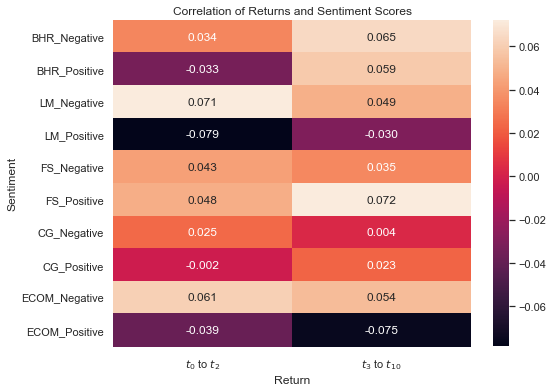

In [5]:
# Correlation matrix
sns.set(rc={"figure.figsize":(8, 6)})    # Set a larger figure size

# Create the correlation matrix
corr = df.filter(regex='^.*_(posi|nega)tive$|^ret_t.*$', axis=1).corr() \
        .filter(regex='^.*_(posi|nega)tive$', axis=0)[['ret_t-t2', 'ret_t3-t10']]

# Plot it as a heatmap with friendly names
sns.heatmap(corr,
            xticklabels=['$t_0$ to $t_2$', '$t_3$ to $t_{10}$'],
            yticklabels=corr.index.map(lambda s: re.sub(r'([a-z]+_[a-z])', lambda x: f'{x[1].upper()}', s)),
            annot=True,
            fmt='.03f',) \
        .set(title='Correlation of Returns and Sentiment Scores', xlabel='Return', ylabel='Sentiment');

We see from the figure that the strongest correlation is between $t_0-t_2$ and LM Positive sentiments with a magnitude of 0.079.  These values are inversely correlated.  This is closely followed by the negative association between E-commerce positive topics and returns from $t_3-t_{10}$ with an absolute magnitude of 0.075.  Financial stability positive sentiments has the highest positive correlation with returns from $t_3-t_{10}$ of 0.072, and LM negative sentiments have the highest positive correlation with returns from $t_0-t_2$ of 0.071.

Both positive and negative sentiments of corporate governance have the least association with either return variable, though both have higher values than many of the other explored contextual sentiment topics.

### Scatterplots and Regressions

Now, we examine sentiments and returns in more detail.  Below the Utilities section we see the plots of sentiment scores versus returns.

#### Utilities 

In [6]:
# Prepend sentiments by sent+ for wide_to_long
df_sent_rets = df.filter(regex='^Symbol$|^.*_(posi|nega)tive$|^ret_t.*$', axis=1)
df_sent_rets = df_sent_rets \
        .rename(columns=lambda x: re.sub('^(.*_(posi|nega)tive)$',r'score+\1',x))

# Combine all sentiments into long columns
df_sent_rets_longer = pd.wide_to_long(
        df_sent_rets,
        stubnames=['score'],
        i='Symbol',
        j='sentiment',
        sep='+',
        suffix='.+').reset_index()

# Add returns
df_sent_rets_longer = df_sent_rets_longer.melt(
        id_vars=['Symbol', 'sentiment','score'],
        value_vars=['ret_t-t2', 'ret_t3-t10'],
        var_name='Return Period',
        value_name='return')

In [7]:
def query_plot_sents(query, extension=False):
    g = sns.lmplot(
            data=df_sent_rets_longer.query(query),
            x='score',
            y='return',
            hue='Return Period',
            col_wrap=2,
            col='sentiment',
            ci=None)

    # Add hovering sentiment name
    for name, ax in g.axes_dict.items():
        ax.text(0.1,
                0.7,
                re.sub(r'([a-z]+_[a-z])', lambda x: f'{x[1].upper()}', name),
                transform=ax.transAxes,
                weight='bold')

    ax.set_xticks(ax.get_xticks())
    g.set_titles('')
    if not extension:
        plt.subplots_adjust(top=0.93)
        plt.suptitle('Sentiment Score versus Return', size='xx-large', weight='bold')
    g.set_axis_labels('Sentiment Score', 'Return')
    g.legend.get_texts()[0].set_text('$t_0-t_2$')
    g.legend.get_texts()[1].set_text('$t_3-t_{10}$')
    plt.show()

#### Scatterplots

Because of the differences in magnitude between the contextual sentiment variables, I separated each topic to have its own x-axis.

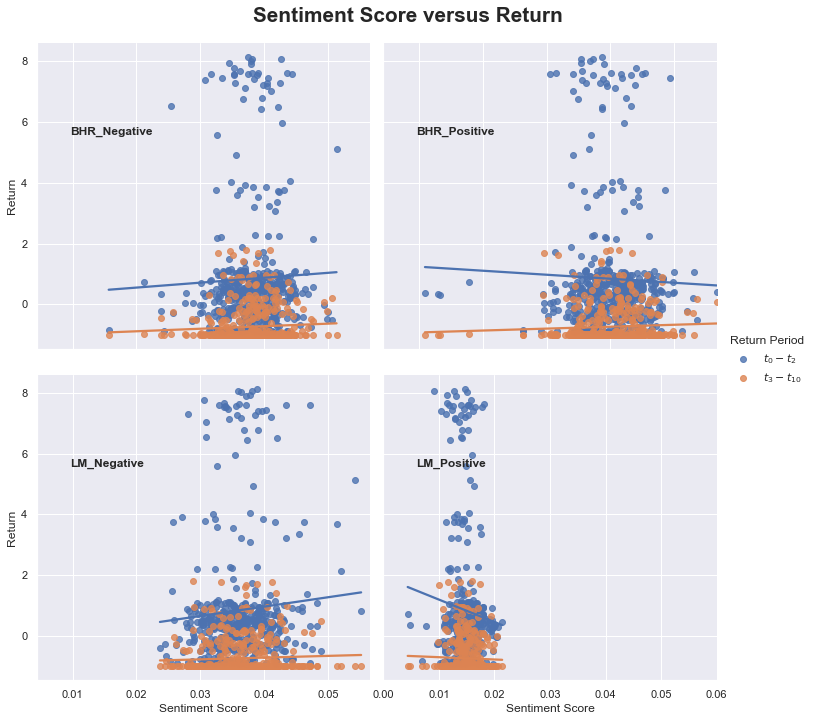

In [8]:
# Display high values of lm and bhr on this graph
query_plot_sents('sentiment.isin(["bhr_positive","bhr_negative","lm_positive","lm_negative"])')

For the ML (BHR) dictionary, we see weak associations between sentiment score and both return variables.  Negative ML sentiments are more closely correlated with increases in share price.  Positive ML sentiments and returns from $t_0$ to $t_2$ have a weak negative correlation and a very weak positive correlation with returns from  $t_3$ to $t_{10}$. 

With the LM dictionary, we see stronger associations, though negative LM sentiments are positively correlated with returns and positive LM sentiments are negatively correlated with returns.

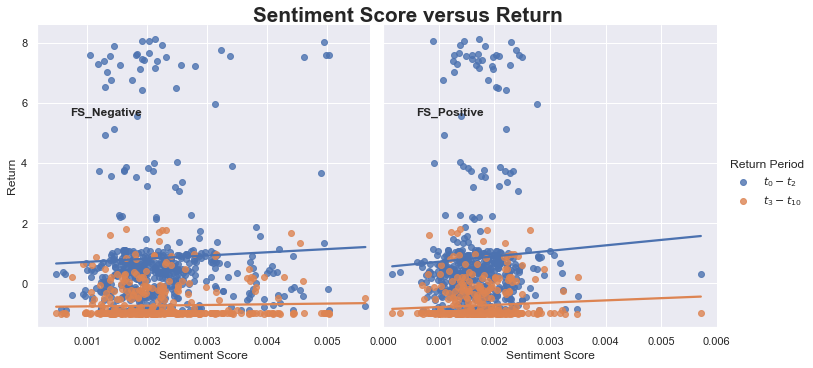

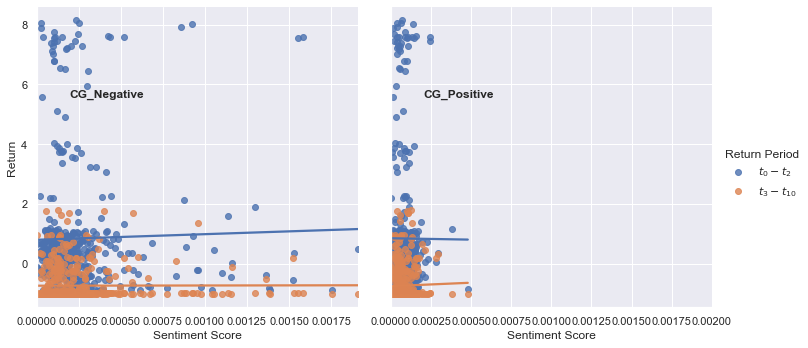

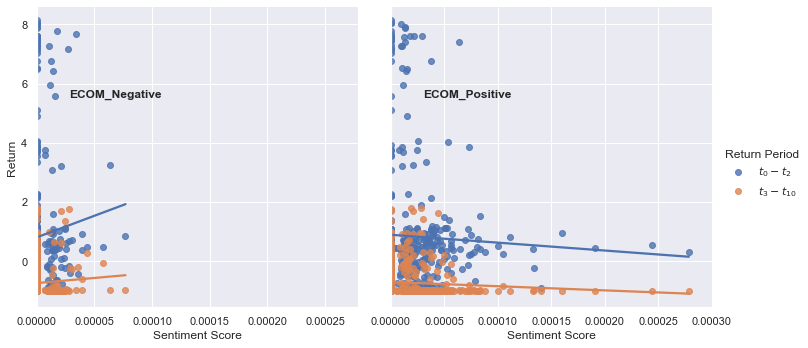

In [9]:
# Display contextual sentiment
query_plot_sents('sentiment.isin(["fs_positive","fs_negative"])')
query_plot_sents('sentiment.isin(["cg_positive","cg_negative"])', True)
query_plot_sents('sentiment.isin(["ecom_positive","ecom_negative"])', True)

Now, we look into the contextual sentiments.  These scores were much lower than the dictionary-based sentiment measures, and because of this, they are more subject to high variance.  However, we see a similar pattern in this data to those shown before.

Negative Financial Stability is somewhat positively correlated with both return periods, though with much more magnitude for the $t_0$ to $t_2$ days than for the longer $t_3$ to $t_{10}$ period.

Positive Financial Stability has a single outlier that extends the distribution, and it has a positive association with both return period variables.

Negative Corporate Governance and Positive Corporate Governance have very different ranges, though both have slopes approaching zero.

Though Negative and Positive E-Commerce has very small values, they have fairly aggressive slopes (likely due to the few documents they appear in).  Negative E-Commerce has a positive slope compared to both return variables, and Positive E-Commerce has a negative slope relative to both return variables.

Note that we expect a lower magnitude of the regression's slope for the time period $t_3$ to $t_{10}$ than $t_0$ to $t_2$ because over a longer period the data should become more normal (regression to the mean).

### Regression

Now, we normalize the data to compare coefficients so that all coefficients are of the same scale.  Fitting the model, we see positive and negative relationships in a nominal way.

In [10]:
# Regress on selected variables
df_ret = df.filter(regex='^.*_(posi|nega)tive$|^ret_t-t2$', axis=1)

# Apply min-max and mean normalization, fixing return
df_ret = (df_ret - df_ret.min()) / (df_ret.max() - df_ret.min())
df_ret = (df_ret - df_ret.mean()) / df_ret.std()
df_ret['ret_t-t2'] = df['ret_t-t2']

# Join all columns with Q("<var>") for regression
non_ret_cols = "+".join(df_ret.columns.difference(['ret_t-t2', 'ret_t3-t10']) \
        .map(lambda s: re.sub('^(.*)$', r'Q("\1")', s)))

# Fit the model
sm_ols('Q("ret_t-t2") ~ ' + non_ret_cols, data=df_ret).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          Q("ret_t-t2")   R-squared:                       0.020
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.9849
Date:                Fri, 24 Mar 2023   Prob (F-statistic):              0.455
Time:                        15:15:19   Log-Likelihood:                -1047.3
No. Observations:                 497   AIC:                             2117.
Df Residuals:                     486   BIC:                             2163.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              0.8468      0.090      9.377      0.000       0.669       1.024
Q("bhr_negative")      0.0065      0.116      0.056      0.955      -0.221       0.234
Q("bhr_positive")     -0.0672      0.108     -0.623      0.534      -0.279       0.145
Q("cg_negative")      -0.0689      0.120     -0.575      0.566      -0.304       0.167
Q("cg_positive")       0.0094      0.097      0.097      0.923      -0.180       0.199
Q("ecom_negative")     0.1231      0.091      1.349      0.178      -0.056       0.302
Q("ecom_positive")    -0.0359      0.094     -0.383      0.702      -0.220       0.148
Q("fs_negative")       0.0784      0.118      0.662      0.508      -0.154       0.311
Q("fs_positive")       0.1163      0.102      1.135      0.257      -0.085       0.318
Q("lm_negative")       0.1155      0.104      1.112      0.267      -0.089       0.320
Q("lm_positive")      -0.1677      0.100     -1.676      0.094      -0.364       0.029
==============================================================================
Omnibus:                      245.670   Durbin-Watson:                   0.054
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              977.403
Skew:                           2.342   Prob(JB):                    5.75e-213
Kurtosis:                       8.026   Cond. No.                         2.47
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### Comparison to Garcia, Hu, and Rohrer's Table

For 1 filing period excess return, my correlations of Positive and Negative LM variables closely match Garcia, Hu, and Rohrer's in sign and magnitude.  The Positive LM Sentiment is also close for 5 and 6 filing periods excess return in magnitude and sign, but my Negative LM Sentiment is much higher for this period (same sign, higher magnitude).

Sign and approximate magnitude are also the same for Positive ML Sentiment of 1 filing period excess return, but the Negative ML Sentiment is the opposite sign and has much higher magnitude compared to theirs.

However, our analyses are very different.  Garcia et al's data is value-normalized.  They include many more firms and restrict those that may show outliers (such as excluding those with a stock price on day before the call of $3 or less, less than 60 days of trading before and after filing date, less than 180 days between filings, and those with more than one 10-K that year).  With over 75,000 observations over many years, the addition of earnings calls, and the inclusion of Wall Street Journal data, their model is likely to perform better than our naive exploration.  The S&P500 firms that we explored are not necessarily representative of the larger market.

#### Value of Contextual Sentiment Measures

My contextual sentiment measures appear to have some value relative to the existing ML and LM dictionaries, though we do not know if this would generalize to a longer time period or new set of firms.

Those documents with Positive E-Commerce sentiments, though few, seem to be fairly correlated with returns relative to other sentiment measures.  This may be because of overall 2022 trends per sector (as E-Commerce text was fairly isolated by industry) which can be explored further.  Those with Negative E-Commerce sentiments also seem to be associated with returns as much as the ML negative sentiments, although this may again be because of their low presence in documents.

Financial Stability as a category seems to be a better contextual sentiment measure because of its applicability across firms and industries.  All firms reporting should make some mention to their performance, and examining whether this contextually indicates increasing or decreasing in value should be related to stock price.  Its correlations are closely aligned with ML sentiments in magnitude and would be interesting to look at over a longer period of time.

For the Corporate Governance category, we see a very low association.  These terms seem less likely to be relevant to our exploration because of the low magnitudes.  They also may often be out of scope of discussion in a 10-K.

#### Difference in Sign and Magnitude Between Return Measures

In general, because $t_3$ to $t_{10}$ has a longer return horizon, we would expect the magnitude of values to be lower and more normalized than the $t_0$ to $t_2$ return variable as it is less subject to large single-day jumps.  From the ML return measures in the heat map, we see that the initial shock of the 10-K's release has a lower absolute correlation with the ML return measure than the return measures over a longer period of time.  It may be that as news is released and the public takes notice, and the true effect of the comments in the 10-Ks take hold.

## References

<a id="1">[1]</a>
Correa, Ricardo, Keshav Garud, Juan-Miguel Londono-Yarce, Nathan Mislang (2017). "Constructing a Dictionary for Financial Stability." IFDP Notes. Washington: Board of Governors of the Federal Reserve System, June 2017, https://doi.org/10.17016/2573-2129.33.

<a id="2">[2]</a>
Diggelmann, Thomas, Jordan Boyd-Graber, Jannis Bulian, Massimiliano Ciaramita, Markus Leippold (2020). "CLIMATE-FEVER: A Dataset for Verification of Real-World Climate Claims." Tackling Climate Change with Machine Learning workshop at NeurIPS 2020, 11 December 2020.

<a id="3">[3]</a>
Goodell, John W, Satish Kumar, Weng Marc Lim, Debidutta Pattnaik (2021).
"Artificial intelligence and machine learning in finance: Identifying foundations, themes, and research clusters from bibliometric analysis."
Journal of Behavioral and Experimental Finance, Volume 32, https://doi.org/10.1016/j.jbef.2021.100577.

<a id="4">[4]</a>
Mushtaq, Rizwan, Ammar Ali Gull, Yasir Shahab, Imen Derouiche (2022), "Do financial performance indicators predict 10-K text sentiments? An application of artificial intelligence," Research in International Business and Finance, Volume 61, 2022. https://doi.org/10.1016/j.ribaf.2022.101679.

<a id="5">[5]</a>
Shea, Yifei, Margit Steiner, Erhard Radatz (2021). "Sustainable Investing Meets Natural Language Processing - a Systematic Framework for Building Customized Theme Portfolios". Risk & Reward, Volume 3/2021, pp. 4-13., https://ssrn.com/abstract=3909330.